In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
import os

In [2]:
# File paths for the CSV files
train_label_path = './data/train_label.csv'
train_data_path = './data/train_data.csv'
test_data_path = './data/test_data.csv'
columns_path = './data/columns.csv'

# Loading the CSV files into pandas DataFrames
train_label_df = pd.read_csv(train_label_path)
train_data_df = pd.read_csv(train_data_path)
test_data_df = pd.read_csv(test_data_path)
columns_df = pd.read_csv(columns_path)

# Display the first few rows of each DataFrame to verify successful loading
print("Train Label Data:")
print(train_label_df.head())
print("\nTrain Data:")
print(train_data_df.head())
print("\nTest Data:")
print(test_data_df.head())
print("\nColumns Data:")
print(columns_df.head())


Train Label Data:
      id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

Train Data:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.155298  Zahan

In [3]:
# Assuming 'train_data_df' is your features and 'train_label_df' is your target
X_train, X_val, y_train, y_val = train_test_split(train_data_df, train_label_df, test_size=0.2, random_state=42)

# Check for missing values in the training set
print(X_train.isnull().sum())

id                           0
amount_tsh                   0
date_recorded                0
funder                    2877
gps_height                   0
installer                 2889
longitude                    0
latitude                     0
wpt_name                     1
num_private                  0
basin                        0
subvillage                 296
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2689
recorded_by                  0
scheme_management         3103
scheme_name              23036
permit                    2439
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

# Handling Missing Values
Before training models, you should handle any missing values in your dataset. First we filled the missing values of some features with the mode, then we droped the feature which was missing the most. Finally, we used SimpleImputer to fill missing numerical values with the median and categorical values with the most frequent category.

In [4]:
# Drop the 'scheme_name' column
X_train.drop('scheme_name', axis=1, inplace=True)
X_val.drop('scheme_name', axis=1, inplace=True)

# Identify numerical and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

# Training Models
## Decision Tree

Decision Tree Classifier Report:

                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      6457
         non functional       0.42      0.37      0.40       851
functional needs repair       0.80      0.77      0.78      4572

               accuracy                           0.78     11880
              macro avg       0.68      0.66      0.67     11880
           weighted avg       0.77      0.78      0.78     11880



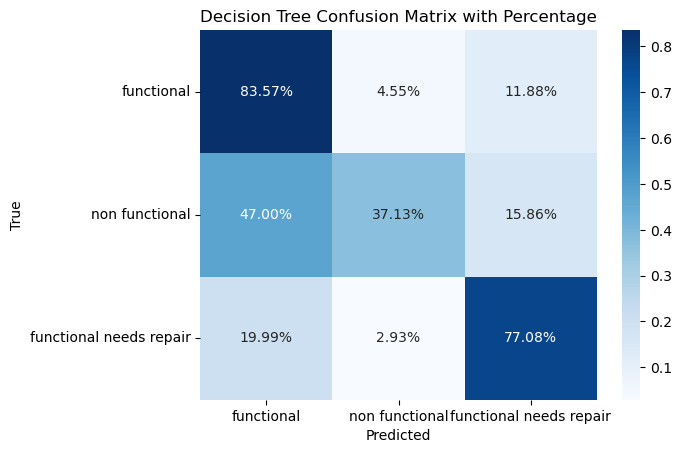

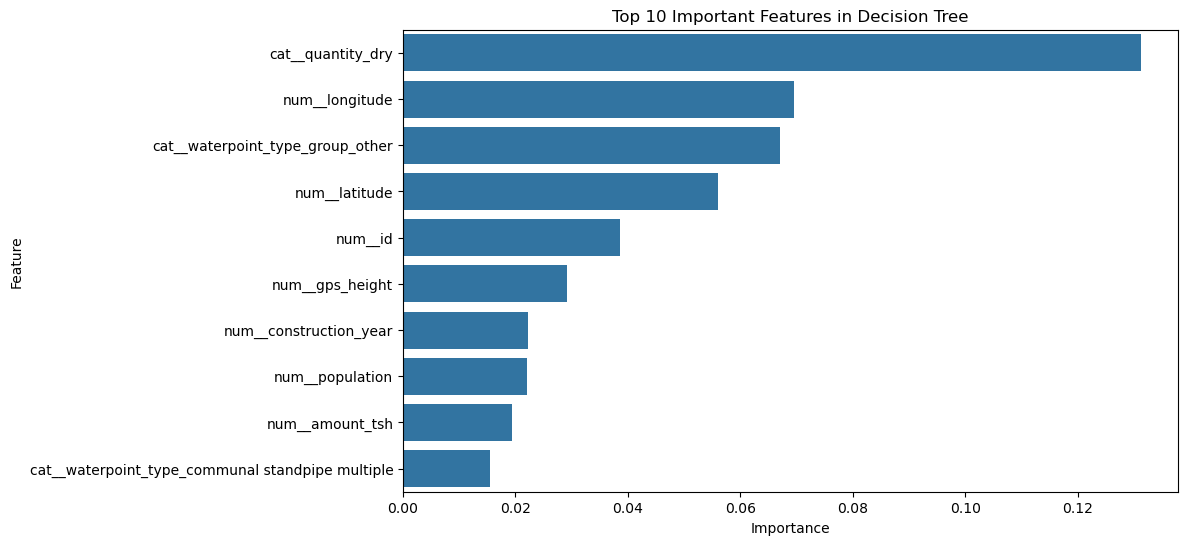

In [5]:
# Ensure that y_train and y_val are in the correct format
# If they are categorical, they should be converted to a consistent type (either all strings or all numeric)
y_train = y_train['status_group'].astype(str)  # Assuming the target column is 'status_group'
y_val = y_val['status_group'].astype(str)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_preprocessed, y_train)

# Predict on validation set
y_val_pred_dt = dt_classifier.predict(X_val_preprocessed)

# Replace 0, 1, 2 with class names
class_names = ['functional', 'non functional', 'functional needs repair']

# Classification Report
print("Decision Tree Classifier Report:\n")
print(classification_report(y_val, y_val_pred_dt, target_names=class_names))

# Confusion Matrix with Percentages
cm = confusion_matrix(y_val, y_val_pred_dt)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix with Percentage')
plt.show()

# Feature Importance Visualization
feature_names = preprocessor.get_feature_names_out()  # Get feature names after preprocessing
importances = dt_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features in Decision Tree')
plt.show()

### Random Forest

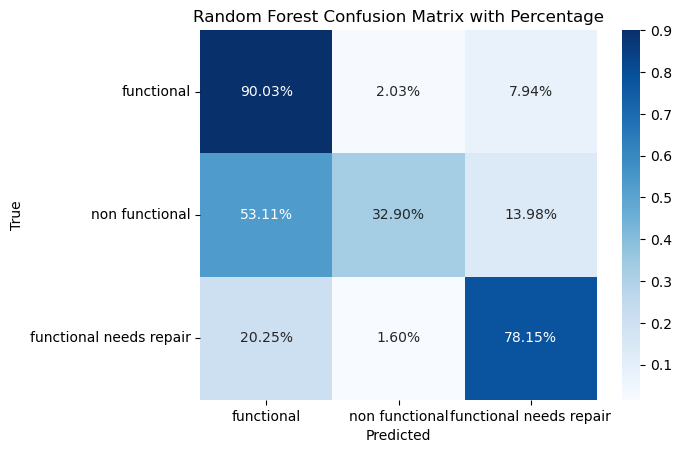

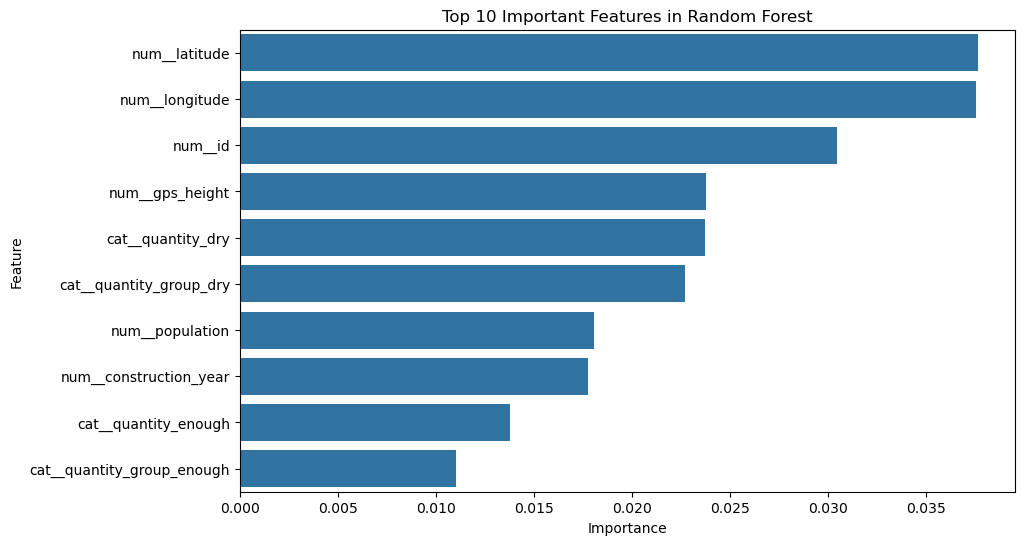

In [7]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_preprocessed, y_train)

# Predict on validation set
y_val_pred_rf = rf_classifier.predict(X_val_preprocessed)



# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
cm_rf_percentage = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_rf_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix with Percentage')
plt.show()

# Feature Importance Visualization for Random Forest
importances_rf = rf_classifier.feature_importances_
importance_rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_rf_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features in Random Forest')
plt.show()

### Gradient Boosting

Gradient Boosting Classifier Report:

                         precision    recall  f1-score   support

             functional       0.77      0.91      0.83      6457
         non functional       0.57      0.24      0.33       851
functional needs repair       0.83      0.71      0.76      4572

               accuracy                           0.78     11880
              macro avg       0.72      0.62      0.64     11880
           weighted avg       0.78      0.78      0.77     11880



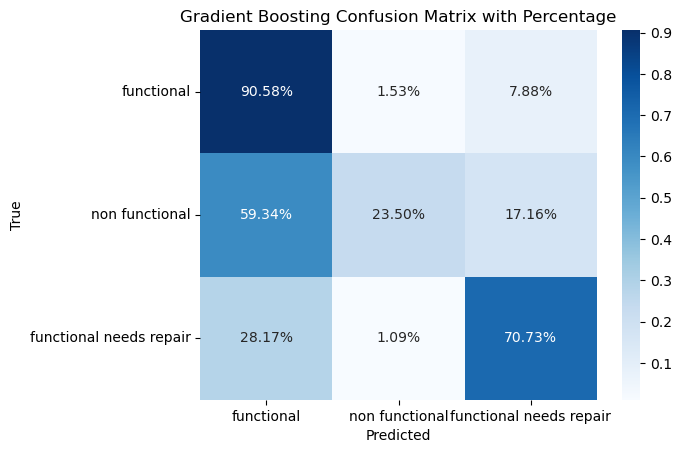

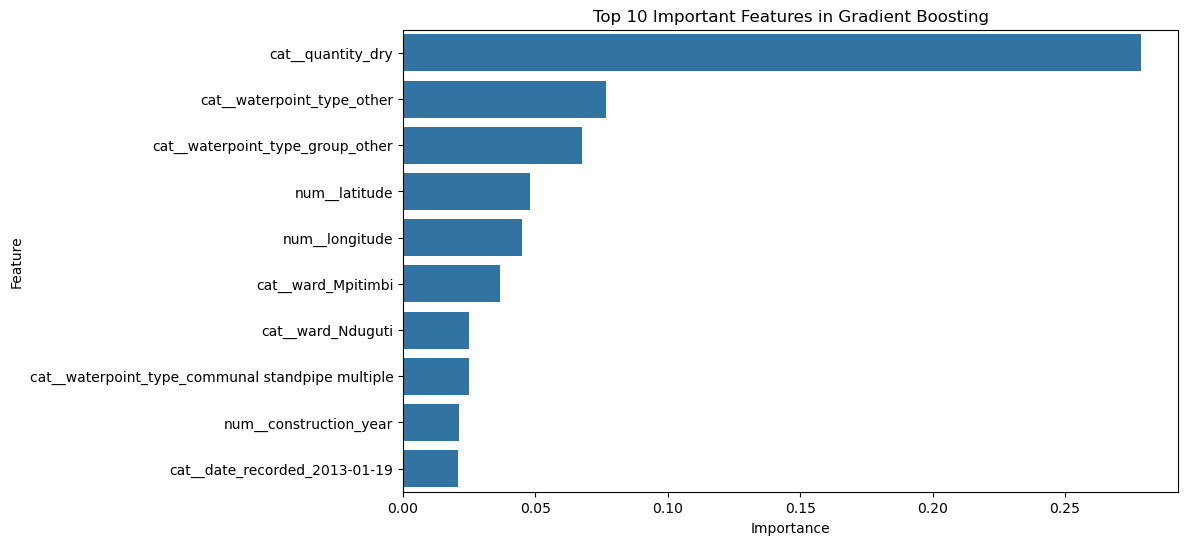

In [8]:
# Instantiate the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)

# Fit the classifier to the training data
gb_classifier.fit(X_train_preprocessed, y_train)

# Predict on the validation set
y_val_pred_gb = gb_classifier.predict(X_val_preprocessed)

# Evaluation
print("Gradient Boosting Classifier Report:\n")
print(classification_report(y_val, y_val_pred_gb, target_names=class_names))

# Confusion Matrix with Percentages
cm_gb = confusion_matrix(y_val, y_val_pred_gb)
cm_gb_percentage = cm_gb.astype('float') / cm_gb.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_gb_percentage, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gradient Boosting Confusion Matrix with Percentage')
plt.show()

# Feature Importance Visualization
importances_gb = gb_classifier.feature_importances_
importance_gb_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_gb_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features in Gradient Boosting')
plt.show()

### Support Vector Machine (SVM)

SVM Classifier Report:

                         precision    recall  f1-score   support

             functional       0.76      0.93      0.84      6457
         non functional       0.72      0.21      0.32       851
functional needs repair       0.86      0.70      0.77      4572

               accuracy                           0.79     11880
              macro avg       0.78      0.61      0.65     11880
           weighted avg       0.80      0.79      0.78     11880



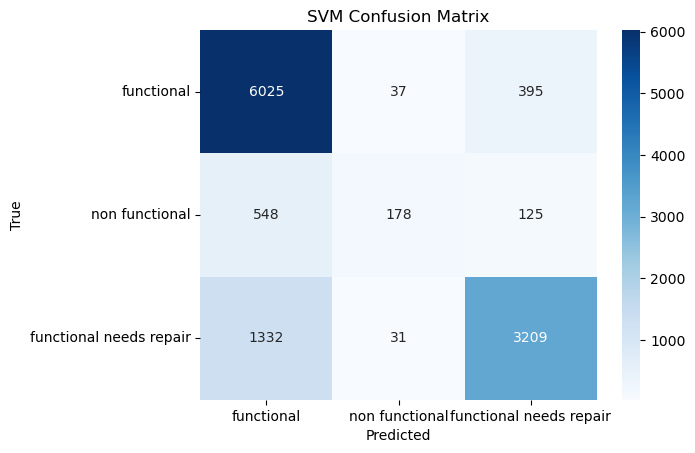

In [9]:
# Instantiate the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1, random_state=42)  # Using RBF kernel and default C value

# Fit the classifier to the training data
svm_classifier.fit(X_train_preprocessed, y_train)

# Predict on the validation set
y_val_pred_svm = svm_classifier.predict(X_val_preprocessed)

# Evaluation
print("SVM Classifier Report:\n")
print(classification_report(y_val, y_val_pred_svm, target_names=class_names))

# Confusion Matrix
cm_svm = confusion_matrix(y_val, y_val_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()